In [1]:
import os
os.chdir('../')
# esse comando é melhor do que sys.path.insert(0, '../') pois permite interagir com arquivos do diretorio acima

In [2]:
import pickle
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 167) # opcional, questão de visualização para debugar caso 1
pd.set_option('display.max_columns', 50)

In [3]:
from pynnystock.FileManager import FileManager
from pynnystock.Ativo import Ativo
# from pynnystock.Parameters import Parameters
# from pynnystock.StatsGatherer import StatsGatherer
# from pynnystock.StratsMaestro import StratsMaestro
from pynnystock.Simulator import Simulator
from pynnystock.BootstrapSimulator import BootstrapSimulator
#from pynnystock.OptimizerSimulator import OptimizerSimulator

In [4]:
# o nome da estratégia é Double Stops VWAP , e o acrônimo DSVW significa: Double Stops VWap
from pynnystock.strategies.doublestopsVWAP.ParametersDSVW import ParametersDSVW
from pynnystock.strategies.doublestopsVWAP.StatsGathererDSVW import StatsGathererDSVW
from pynnystock.strategies.doublestopsVWAP.StratsMaestroDSVW import StratsMaestroDSVW
from pynnystock.strategies.doublestopsVWAP.OptimizerSimulatorDSVW import OptimizerSimulatorDSVW

In [5]:
fm = FileManager()

In [6]:
pars = ParametersDSVW()

In [7]:
sg = StatsGathererDSVW(pars)

##### Na primeira vez precisa gerar o pickle de ativo_dia_list.pkl
##### Somente executar esse código se o pickle ativo_dia_list.pkl não tiver sido gerado

In [ ]:
# abre arquivo com freefloats
names_pennystocks = fm.getNames()
names_free_float = fm.getFreeFloatNames()
names = list(set(names_pennystocks) & set(names_free_float))
names.sort()

In [ ]:
# gera ativo_dia_list (adl), que é uma lista com resumo dos dias que vai nos auxiliar a filtrar os dias de interesse
# também vai auxiliar na análise de ativos-dia
adl = []
for n in names[0:10]:
#for n in names:
    print(n)
    try:
        a = Ativo(n, fm[n], sg)
        for intraday in a.intraDays:
            d = {'name': a.name,
                 'date': intraday.date,
                 'freefloat': fm.getFreeFloat(n),
                 'stats': intraday.stats}
            adl.append( d )
    except IndexError:
        print("Ativo sem nenhum dado ou dado inconsistente")

In [ ]:
with open('AtivoDiaList.pkl', 'wb') as filehandle: # w de write e b de binary
    pickle.dump(adl,filehandle)

##### Com o pickle ativo_dia_list.pkl gerado, prosseguir daqui

In [8]:
with open('AtivoDiaList.pkl', 'rb') as filehandle:
    ativo_dia_list = pickle.load(filehandle)

In [9]:
sm = StratsMaestroDSVW(pars)

In [10]:
sim = Simulator(fm,ativo_dia_list,pars,sm,sg)

In [11]:
bss = BootstrapSimulator(sg)

In [12]:
os = OptimizerSimulatorDSVW(sim, bss, sg)

In [13]:
pars.setFilterParameters(prevol_threshold=800000,open_dolar_threshold=2,gap_threshold=0.2,F_low_threshold=0,F_high_threshold=1)
#pars.setFilterParameters(prevol_threshold=15000000,open_dolar_threshold=2,gap_threshold=0.2,F_low_threshold=0,F_high_threshold=1)
sim.runFiltering()

In [14]:
pars.setAlgoParameters(short_after = 0.1,exit_target = 0.3, exit_stop = 0.3, vwap_distance = 0.20, vwap_timer_minutes = 10, 
                       vwap_pct = 0.5, exit_after_minutes = 60)
pars.setSimParameters(start_money = 10000, allocation=0.1, locate_fee=0.02, commission=2)

sim.runSimulation()

#sim.saveTrades('case1_trades.pkl')
# sim.openTrades('case1_trades.pkl')

In [15]:
dfd = sg.filtereddf # DataFrame of filtered ativo-dias
dft = sg.tradesdf # DataFrame of trades
dfes = sg.extrastatsdf # DataFrame of extra statistics

In [16]:
dfd

,name,date,freefloat,volPre,gap,openToSpike%,minsToSpike,volToSpike,spikeToLow%,minsToLowAfterSpike,spikeToPreVolF,factorF
0,ABIO,2020-05-28,9294353.0,1699419.0,1.283673,1.494331,370.0,77621427.0,-0.145273,19.0,45.675273,1.378860
1,ABUS,2020-05-19,61552279.0,1501666.0,0.454054,0.000000,0.0,378734.0,-0.152416,107.0,0.252209,0.064996
2,ABUS,2020-07-24,61552279.0,15640564.0,0.289197,0.130326,3.0,13391918.0,-0.471175,362.0,0.856230,1.868844
3,ACHV,2020-07-29,3599669.0,843766.0,0.391546,0.112375,3.0,304103.0,-0.302169,304.0,0.360412,3.970188
4,ACHV,2020-07-31,3599669.0,2587621.0,0.434214,0.061011,19.0,1003228.0,-0.342826,52.0,0.387703,13.858157
...,...,...,...,...,...,...,...,...,...,...,...,...
306,XTNT,2020-10-02,69360369.0,21411236.0,1.742899,0.111111,0.0,3299514.0,-0.464000,266.0,0.154102,0.581932
307,YCBD,2020-05-19,33532871.0,1183644.0,0.235294,0.042857,2.0,1496341.0,-0.269406,100.0,1.264182,0.073354
308,YRCW,2020-07-01,46435103.0,8239098.0,0.777174,0.085627,175.0,45686074.0,-0.194366,56.0,5.545033,0.698236
309,YTEN,2020-02-07,2340576.0,1024270.0,0.244218,0.092193,0.0,531054.0,-0.430225,369.0,0.518471,5.403158


In [17]:
dft

,name,date,has_trade,has_vwap_exit,has_time_exit,entry_time,minutes_to_trade,price,stop,target,exit_time,minutes_in_trade,profit,exit_vwap_time,minutes_to_vwap,profit1_vwap,profit2_vwap,equity_real,profit_real,cum_profit_real
0,XNET,2019-10-28,1.0,0.0,1.0,09:49,18.0,6.687670,8.693971,4.681369,10:49,60.0,0.028944,NaN,NaN,NaN,NaN,10006.944311,0.000694,1.000694
1,ARAV,2019-11-20,1.0,1.0,0.0,09:33,2.0,14.806000,19.247800,10.364200,10:24,51.0,0.218756,09:43,10.0,0.137512,0.300000,10203.838243,0.019676,1.020384
2,CGIX,2019-11-20,1.0,0.0,1.0,10:10,39.0,6.336000,8.236800,4.435200,11:10,60.0,0.048611,NaN,NaN,NaN,NaN,10231.032558,0.002665,1.023103
3,VIVE,2019-11-22,1.0,1.0,1.0,09:32,1.0,3.344000,4.347200,2.340800,10:32,60.0,0.228469,10:23,51.0,0.219498,0.237440,10442.317768,0.020651,1.044232
4,ASLN,2019-12-02,1.0,0.0,1.0,09:36,5.0,7.370000,9.581000,5.159000,10:36,60.0,0.204885,NaN,NaN,NaN,NaN,10633.380213,0.018297,1.063338
5,AMRX,2019-12-12,1.0,0.0,1.0,10:53,82.0,5.159000,6.706700,3.611300,11:53,60.0,-0.002132,NaN,NaN,NaN,NaN,10607.846207,-0.002401,1.060785
6,RAD,2019-12-19,1.0,0.0,1.0,10:37,66.0,12.089000,15.715700,8.462300,11:37,60.0,-0.006154,NaN,NaN,NaN,NaN,10578.102069,-0.002804,1.057810
7,SVRA,2019-12-30,1.0,0.0,1.0,09:31,0.0,4.532000,5.891600,3.172400,10:31,60.0,0.229921,NaN,NaN,NaN,NaN,10798.158185,0.020803,1.079816
8,CEI,2020-01-08,1.0,0.0,1.0,10:26,55.0,4.092000,5.319600,2.864400,11:26,60.0,0.142229,NaN,NaN,NaN,NaN,10928.142711,0.012038,1.092814
9,AGTC,2020-01-09,1.0,0.0,1.0,12:06,155.0,7.315000,9.509500,5.120500,13:06,60.0,-0.070403,NaN,NaN,NaN,NaN,10827.348716,-0.009223,1.082735


In [18]:
dfes

,name,date,open_pre,high_pre,low_pre,close_pre,open_core,high_core,low_core,close_core
0,NNDM,2019-10-23,2.95,4.70,2.95,4.49,4.5000,4.86,2.800,3.21
1,XNET,2019-10-28,4.62,6.67,4.62,6.02,6.0797,6.83,5.380,5.68
2,RDHL,2019-11-04,8.44,9.91,8.00,8.44,8.4300,8.55,7.270,7.31
3,FPAY,2019-11-05,2.14,2.93,2.10,2.34,2.3600,2.36,1.740,1.76
4,IFRX,2019-11-07,3.26,3.88,2.93,3.06,3.1000,3.10,2.573,2.70
...,...,...,...,...,...,...,...,...,...,...
306,WWR,2020-10-06,8.35,18.50,8.33,12.47,12.5000,14.50,9.300,11.72
307,OPTT,2020-10-07,2.90,4.38,2.47,3.19,3.1800,3.72,2.680,2.97
308,SUNW,2020-10-07,2.91,5.19,2.91,4.58,4.5900,4.85,3.730,4.05
309,AREC,2020-10-07,1.79,3.30,1.79,3.12,3.0900,4.93,2.470,2.53


##### Algumas análises da simulação

In [19]:
sg.printSimResults()


PARÂMETROS PARA ALGORITMO DO TIPO DOUBLE STOP VWAP
FILTERING PARAMETERS
prevol_threshold: 800000
open_dolar_threshold: 2
gap_threshold: 0.2
F_low_threshold: 0
F_high_threshold: 1

TRADING PARAMETERS
short_after: 0.1
exit_target: 0.3
exit_stop: 0.3
vwap_distance: 0.2
vwap_timer_minutes: 10
vwap_pct: 0.5
exit_after_minutes: 60

SIMULATION PARAMETERS
start_money: 10000
allocation: 0.1
locate_fee: 0.02
commission: 2

Start Money: $10,000.00
End Money: $16,629.51
Number of Trades: 167
Number of filtered ativo-dias: 311
Max Drawdown: 0.14010069417770554


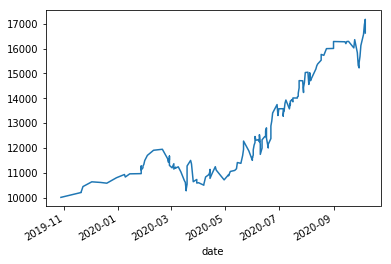

In [20]:
sg.plotEquityCurve()

##### Análise de algumas estratificações

In [21]:
dftr = pd.merge(dft,dfd,how='inner',on=['name','date'])
# dftr = dftr[['name','date','gap','factorF','profit']] # pegar as columns que tu quiser
dftr

,name,date,has_trade,has_vwap_exit,has_time_exit,entry_time,minutes_to_trade,price,stop,target,exit_time,minutes_in_trade,profit,exit_vwap_time,minutes_to_vwap,profit1_vwap,profit2_vwap,equity_real,profit_real,cum_profit_real,freefloat,volPre,gap,openToSpike%,minsToSpike,volToSpike,spikeToLow%,minsToLowAfterSpike,spikeToPreVolF,factorF
0,XNET,2019-10-28,1.0,0.0,1.0,09:49,18.0,6.687670,8.693971,4.681369,10:49,60.0,0.028944,NaN,NaN,NaN,NaN,10006.944311,0.000694,1.000694,65521921.0,2980390.0,0.259833,0.123411,21.0,14236135.0,-0.190337,361.0,4.776601,0.272726
1,ARAV,2019-11-20,1.0,1.0,0.0,09:33,2.0,14.806000,19.247800,10.364200,10:24,51.0,0.218756,09:43,10.0,0.137512,0.300000,10203.838243,0.019676,1.020384,10282117.0,2643093.0,1.011958,0.160475,2.0,730289.0,-0.385403,387.0,0.276301,5.330140
2,CGIX,2019-11-20,1.0,0.0,1.0,10:10,39.0,6.336000,8.236800,4.435200,11:10,60.0,0.048611,NaN,NaN,NaN,NaN,10231.032558,0.002665,1.023103,3476190.0,1748394.0,1.755981,0.352431,62.0,9747949.0,-0.401797,321.0,5.575373,2.848012
3,VIVE,2019-11-22,1.0,1.0,1.0,09:32,1.0,3.344000,4.347200,2.340800,10:32,60.0,0.228469,10:23,51.0,0.219498,0.237440,10442.317768,0.020651,1.044232,21650985.0,1492107.0,0.369431,0.151316,1.0,482841.0,-0.755571,388.0,0.323597,0.245800
4,ASLN,2019-12-02,1.0,0.0,1.0,09:36,5.0,7.370000,9.581000,5.159000,10:36,60.0,0.204885,NaN,NaN,NaN,NaN,10633.380213,0.018297,1.063338,36304845.0,1656163.0,0.753927,0.220896,5.0,2565503.0,-0.388753,314.0,1.549064,0.316165
5,AMRX,2019-12-12,1.0,0.0,1.0,10:53,82.0,5.159000,6.706700,3.611300,11:53,60.0,-0.002132,NaN,NaN,NaN,NaN,10607.846207,-0.002401,1.060785,94484724.0,4062180.0,0.343840,0.140725,247.0,30289689.0,-0.134449,44.0,7.456511,0.197234
6,RAD,2019-12-19,1.0,0.0,1.0,10:37,66.0,12.089000,15.715700,8.462300,11:37,60.0,-0.006154,NaN,NaN,NaN,NaN,10578.102069,-0.002804,1.057810,53532585.0,1634076.0,0.316168,0.137398,70.0,16231331.0,-0.078400,84.0,9.933033,0.320711
7,SVRA,2019-12-30,1.0,0.0,1.0,09:31,0.0,4.532000,5.891600,3.172400,10:31,60.0,0.229921,NaN,NaN,NaN,NaN,10798.158185,0.020803,1.079816,39732838.0,6493360.0,1.381503,0.262136,384.0,45659417.0,-0.065385,4.0,7.031709,0.568140
8,CEI,2020-01-08,1.0,0.0,1.0,10:26,55.0,4.092000,5.319600,2.864400,11:26,60.0,0.142229,NaN,NaN,NaN,NaN,10928.142711,0.012038,1.092814,25000000.0,832914.0,0.219632,0.102151,55.0,5693840.0,-0.302439,119.0,6.836048,0.116097
9,AGTC,2020-01-09,1.0,0.0,1.0,12:06,155.0,7.315000,9.509500,5.120500,13:06,60.0,-0.070403,NaN,NaN,NaN,NaN,10827.348716,-0.009223,1.082735,21596974.0,3006369.0,0.594724,0.428571,374.0,36905147.0,-0.040000,12.0,12.275654,0.907599


In [22]:
bins = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2]
gap = np.clip( dftr['gap'], bins[0], bins[-1] )
dftr.groupby(pd.cut(gap, bins)).agg(
    winrate=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x>=0)/(sum(x>=0) + sum(x<0)) ),
    lossrate=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x<0)/(sum(x>=0) + sum(x<0)) ),
    mean=pd.NamedAgg(column='profit',aggfunc=lambda x: x.mean()),
    mean_of_pos=pd.NamedAgg(column='profit',aggfunc=lambda x: x[x>=0].mean()),
    mean_of_neg=pd.NamedAgg(column='profit',aggfunc=lambda x: x[x<0].mean()),
    count=pd.NamedAgg(column='profit',aggfunc='count'),
    positives=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x>=0) ),
    negatives=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x<0) )
)

,winrate,lossrate,mean,mean_of_pos,mean_of_neg,count,positives,negatives
gap,,,,,,,,
"(0.2, 0.3]",0.812500,0.187500,0.052168,0.109311,-0.195453,32,26.0,6.0
"(0.3, 0.4]",0.583333,0.416667,0.040680,0.156863,-0.121976,12,7.0,5.0
"(0.4, 0.5]",0.473684,0.526316,-0.009961,0.141970,-0.146699,19,9.0,10.0
"(0.5, 0.6]",0.800000,0.200000,0.060454,0.102501,-0.107735,20,16.0,4.0
"(0.6, 0.7]",0.687500,0.312500,0.080047,0.156608,-0.088388,16,11.0,5.0
"(0.7, 0.8]",0.857143,0.142857,0.055858,0.115168,-0.300000,7,6.0,1.0
"(0.8, 0.9]",0.600000,0.400000,0.036614,0.170576,-0.164328,10,6.0,4.0
"(0.9, 1.0]",0.500000,0.500000,0.091162,0.211318,-0.028994,2,1.0,1.0
"(1.0, 1.1]",0.625000,0.375000,0.103499,0.228125,-0.104212,8,5.0,3.0


In [23]:
dftr.groupby(dftr['date'].dt.to_period('M')).agg(
    winrate=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x>=0)/(sum(x>=0) + sum(x<0)) ),
    lossrate=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x<0)/(sum(x>=0) + sum(x<0)) ),
    mean=pd.NamedAgg(column='profit',aggfunc=lambda x: x.mean()),
    mean_of_pos=pd.NamedAgg(column='profit',aggfunc=lambda x: x[x>=0].mean()),
    mean_of_neg=pd.NamedAgg(column='profit',aggfunc=lambda x: x[x<0].mean()),
    count=pd.NamedAgg(column='profit',aggfunc='count'),
    positives=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x>=0) ),
    negatives=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x<0) )
)

,winrate,lossrate,mean,mean_of_pos,mean_of_neg,count,positives,negatives
date,,,,,,,,
2019-10,1.000000,0.000000,0.028944,0.028944,NaN,1,1.0,0.0
2019-11,1.000000,0.000000,0.165279,0.165279,NaN,3,3.0,0.0
2019-12,0.500000,0.500000,0.106630,0.217403,-0.004143,4,2.0,2.0
2020-01,0.800000,0.200000,0.084658,0.129599,-0.095104,10,8.0,2.0
2020-02,0.666667,0.333333,0.004635,0.124269,-0.234632,9,6.0,3.0
2020-03,0.476190,0.523810,-0.007196,0.170852,-0.169058,21,10.0,11.0
2020-04,0.642857,0.357143,0.032006,0.137014,-0.157008,14,9.0,5.0
2020-05,0.727273,0.272727,0.117829,0.202571,-0.108148,11,8.0,3.0
2020-06,0.718750,0.281250,0.059034,0.167202,-0.217395,32,23.0,9.0


##### Analisando o Dataframe com extra statistics

In [ ]:
# aqui podemos fazer alguma análise, basta fazer inner join de dfes com os outros dataframes dfd, dft
dfes

##### Rodando Bootstrap

In [24]:
bss.runBootstrap()

In [25]:
sg.printBootstrapResults()

Max Drawdown: 0.14010069417770554
Mean of max Drawdown: 0.1344832834563008
Max of max Drawdown: 0.27003092768732695
Min of max Drawdown: 0.07027823974014835


##### Códigos para rodar combinações de parâmetros e otimizar.

In [26]:
os.runSimulationGroup(
    prevol_threshold=[15000000], # rodar com 15000000 se quiser debugar essa parte
    open_dolar_threshold=[2],
    gap_threshold=[0.2],
    F_low_threshold=[0],
    F_high_threshold=[1],
    short_after=[0],
    exit_target=[0.3],
    exit_stop=[0.3],
    vwap_distance=[0.2, 0.3], 
    vwap_timer_minutes=[10],
    vwap_pct=[0.5],
    exit_after_minutes=[60, 100],
    start_money=[10000],
    allocation=[0.1],
    locate_fee=[0.02],
    commission=[2]
)

Simulando 4 combinações de parâmetros.
running another simulation. 15/01/2021 21:44:52
running another simulation. 15/01/2021 21:45:04
running another simulation. 15/01/2021 21:45:17
running another simulation. 15/01/2021 21:45:32


In [27]:
sg.groupResults

,prevol_threshold,open_dolar_threshold,gap_threshold,F_low_threshold,F_high_threshold,short_after,exit_target,exit_stop,vwap_distance,vwap_timer_minutes,vwap_pct,exit_after_minutes,start_money,allocation,locate_fee,commission,end_money,profit,max_drawdown,meanmax_drawdown,maxmax_drawdown,minmax_drawdown,n_trades,n_filtered_ativo_days
0,15000000,2,0.2,0,1,0,0.3,0.3,0.2,10,0.5,60,10000,0.1,0.02,2,10832.300075,0.083230,0.048266,0.054769,0.080581,0.0322,22,22
1,15000000,2,0.2,0,1,0,0.3,0.3,0.2,10,0.5,100,10000,0.1,0.02,2,11519.557517,0.151956,0.035632,0.050192,0.078191,0.0322,22,22
2,15000000,2,0.2,0,1,0,0.3,0.3,0.3,10,0.5,60,10000,0.1,0.02,2,10900.550901,0.090055,0.045297,0.058399,0.098345,0.0322,22,22
3,15000000,2,0.2,0,1,0,0.3,0.3,0.3,10,0.5,100,10000,0.1,0.02,2,11528.264141,0.152826,0.032629,0.052800,0.102774,0.0322,22,22


In [ ]:
# sg.saveGroupResults('teste1.pkl')
sg.appendGroupResults('teste1.pkl')
# sg.openGroupResults('teste1.pkl')

##### Descrição simulações já rodadas

##### Testes temporários em geral

In [ ]:
sim.trades[0]['trade']

In [ ]:
sum(x['trade'] is not None for x in sim.trades)

In [ ]:
sg.n_trades

In [ ]:
len(sim.trades)

In [ ]:
sum(x['trade']['has_trade'] is not False for x in sim.trades)

In [ ]:
intra = Ativo.initIntradayFromDate('ABUS',fm['ABUS'],datetime.date(2020, 7, 24), sg)

In [ ]:
intra._core

In [ ]:
bar=intra._core[0]

In [ ]:
datetime.datetime(2020, 7, 24, 9, 31)

In [ ]:
datetime(2020, 7, 24, 9, 31)

In [ ]:
intra._core[0]['time']

In [ ]:
type(datetime.datetime)

In [ ]:
sim.trades

In [ ]:
t = sim.trades[0]
t

In [ ]:
from pynnystock.Utilities import minutesDifference

In [ ]:
minutesDifference(t['trade']['entry']['time'].time(), datetime.time(9,31))